### Inundation Risk Modelling With HAND Model using `PySheds`
This notebook demonstrates flood risk assessment using the Height Above Nearest Drainage (HAND) model. By using Digital Elevation Models (DEMs) and calculating the vertical distance of terrain points from the drainage network, the HAND model helps classify areas based on their flood risk potential. The workflow is implemented with Python libraries such as rasterio, numpy, Pysheds, and matplotlib. The notebook covers data preparation, HAND calculation, and flood risk classification with clear, reproducible steps.

With consideration of rainfall and terrain involves leveraging the library’s capabilities for flow direction, flow accumulation, and watershed delineation from a Digital Elevation Model (DEM). Here’s a step-by-step guide:

Reference:
https://mattbartos.com/pysheds/hand.html

Pysheds, https://mattbartos.com/pysheds/

#### Conducting flooding vulnerability analysis using PySheds
with consideration of rainfall and terrain involves leveraging the library’s capabilities for flow direction, flow accumulation, and watershed delineation from a Digital Elevation Model (DEM). Here’s a step-by-step guide:

##### 1.1 Prepare the required module

In [214]:
# !pip install pysheds

In [215]:
import pysheds

##### 1.2. Obtain the Data

You will need:
- Digital Elevation Model (DEM):
- High-resolution raster file (e.g., GeoTIFF).
-	Sources: USGS Earth Explorer, Copernicus DEM, or other DEM providers.
- 2	Rainfall Data:
-	Rainfall intensity or total precipitation (in mm) as input.
-	Can be spatially distributed or a uniform rainfall rate.

#### 2. Computing the height above nearest drainage


##### 2.1 computing the flow directions and accumulation for a given DEM
Make sure your DEM is projected in projection of 4326.


In [228]:
import numpy as np
from pysheds.grid import Grid

# Instantiate grid from raster
grid = Grid.from_raster('dem.tiff')
dem = grid.read_raster('dem.tiff')

# Resolve flats and compute flow directions
inflated_dem = grid.resolve_flats(dem)
fdir = grid.flowdir(inflated_dem)

# Compute accumulation
acc = grid.accumulation(fdir)

##### 2.2 Compute the height above nearest drainage
We can then compute the height above nearest drainage (HAND) by providing a DEM, a flow direction grid, and a channel mask. For this demonstration, we will take the channel mask to be all cells with accumulation greater than 200.



In [217]:
# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc > 200)

##### 2.3 Check the calculated HAND results

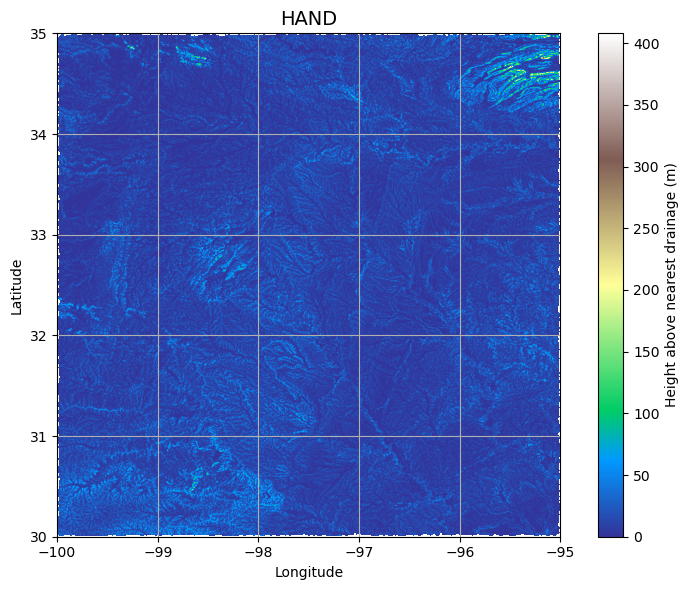

In [218]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.imshow(hand, 
           extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Height above nearest drainage (m)')
plt.grid(zorder=0)
plt.title('HAND', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

The whole area is too big, we will clip the HAND raster to a catchment to make it easier to work with.


In [219]:
# Specify outlet
x, y = -97.294167, 32.73750

# Delineate a catchment
catch = grid.catchment(x=x, y=y, fdir=fdir, xytype='coordinate')

# # Clip to the catchment
grid.clip_to(catch)

# Create a view of HAND in the catchment
hand_view = grid.view(hand, nodata=np.nan)

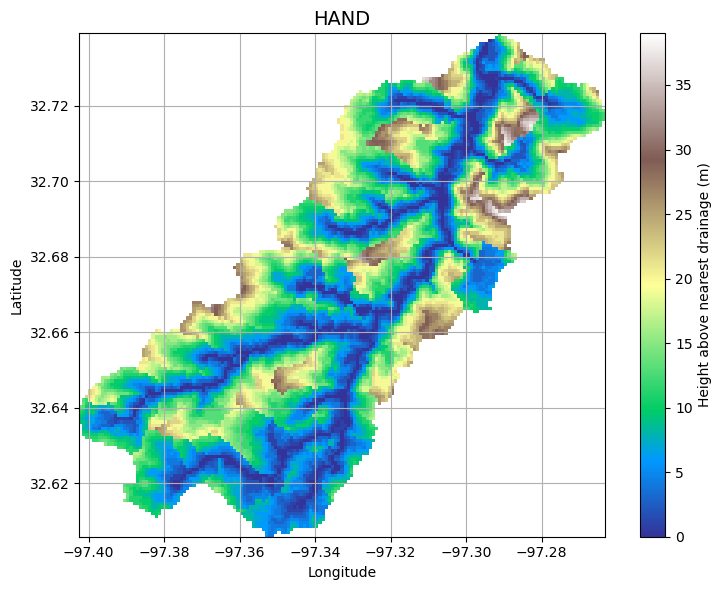

In [220]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.imshow(hand_view, 
           extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Height above nearest drainage (m)')
plt.grid(zorder=0)
plt.title('HAND', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

#### Estimating inundation extent (constant channel depth)
We can estimate the inundation extent (assuming a constant channel depth) using a simple binary threshold:

Explanation of the function `numpy.where(condition, x, y)`, 

condition: A boolean condition that is evaluated on the array.
x (optional): Values to select when the condition is True.
y (optional): Values to select when the condition is False.

In [222]:
threshold = 3

#if the hand value is larger than threshold, then use nan
inundation_extent = np.where(hand_view < threshold, threshold - hand_view, np.nan) 

Let's plot the inudation area

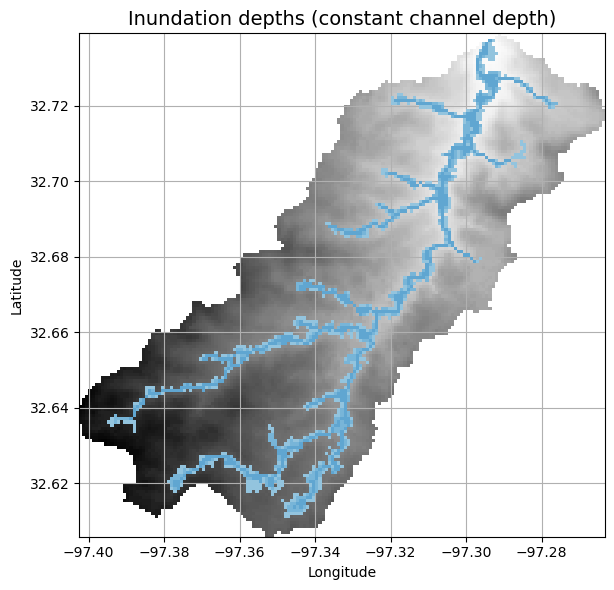

In [223]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(dem_view, extent=grid.extent, cmap='Greys', zorder=1)
plt.imshow(inundation_extent, extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=2)
plt.grid(zorder=0)
plt.title('Inundation depths (constant channel depth)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

#### Export the generated results into a geotiff

In [233]:
def save_geotiff(output_file, res_npy, grid):
    """
    a function to save the result numpy array as a geotiff
    Parameters:
        output_file: the output file name
        res_npy: the output numpy array
        grid: the grid object the save the meta data of the geotiff, the same as the input dem
    """
    
    transform = grid.affine
    crs = grid.crs
    
    # Save the HAND array as a GeoTIFF
    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        height=res_npy.shape[0],
        width=res_npy.shape[1],
        count=1,  # Single-band raster
        dtype=res_npy.dtype,
        crs=crs,
        transform=transform, 
        compress='LZW' #compress the raster data using LZW
    ) as dst:
        dst.write(res_npy, 1)  # Write the HAND data to the first band
    
    print(f"HAND result saved to {output_file}")

In [234]:
# Get the transform and CRS from the grid
# transform = grid.affine
# crs = grid.crs
# transform, crs

In [235]:
output_file = "dem_hand_res.tif"
save_geotiff(output_file, hand, grid)

HAND result saved to dem_hand_res.tif


#### Export the inundation results

In [236]:
threshold = 3

#if the hand value is larger than threshold, then use nan
inundation_extent = np.where(hand < threshold, threshold - hand, np.nan) 

output_file = "dem_inundation_res.tif"
save_geotiff(output_file, inundation_extent, grid)


HAND result saved to dem_inundation_res.tif


### Section 2. Let use our own data in Pennsylvania

Download the DEM data for Delaware County from USGS website

In [255]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import pysheds
import numpy as np

dem_path = 'USGS_1_n40w076_20220524.tif'

# Read raw DEM
grid = Grid.from_raster(dem_path)
dem = grid.read_raster(dem_path)

In [256]:
grid.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### Reproject the raster data into WGS84, 4326 and save the new geotiff


In [257]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Input and output file paths
src_path = 'USGS_1_n41w076_20221115.tif'
dst_path = 'USGS_1_n41w076_20221115_wgs84.tif'

# Reproject raster to EPSG:4326
with rasterio.open(src_path) as src:
    # Define target CRS
    dst_crs = 'EPSG:4326'
    
    # Calculate transform and output dimensions
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    # Update metadata
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Write reprojected raster
    with rasterio.open(dst_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print(f"Reprojected raster saved at: {dst_path}")

Reprojected raster saved at: USGS_1_n41w076_20221115_wgs84.tif


#### Detecting pits

Detecting pits (depressions or sinks) in a Digital Elevation Model (DEM) is an essential step in hydrological analysis. Pits are areas where water cannot flow out because they are surrounded by higher terrain. Detecting and handling pits ensures accurate flow direction and accumulation computations.

Pits can be detected using the `grid.detect_depressions` method:

In [258]:
demfile = 'USGS_1_n41w076_20221115_wgs84.tif'

# Read raw DEM
grid = Grid.from_raster(demfile)
dem = grid.read_raster(demfile)

# Detect pits
pits = grid.detect_pits(dem)

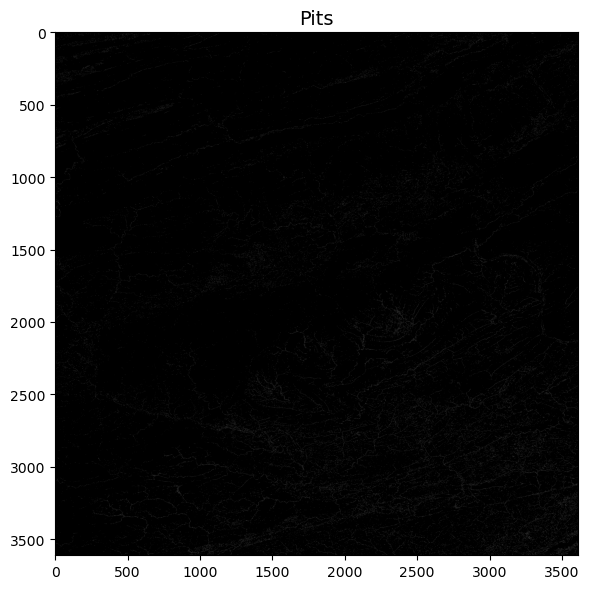

In [259]:
# Plot pits
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(pits, cmap='Greys_r', zorder=1)
plt.title('Pits', size=14)
plt.tight_layout()

#### Filling pits
Pits can be filled using the `grid.fill_pits` method:


In [260]:
# Fill pits
pit_filled_dem = grid.fill_pits(dem)
pits = grid.detect_pits(pit_filled_dem)
assert not pits.any()

#### Detecting depressions
Depressions can be detected using the `grid.detect_depressions` method:


In [261]:
# Detect depressions
depressions = grid.detect_depressions(pit_filled_dem)

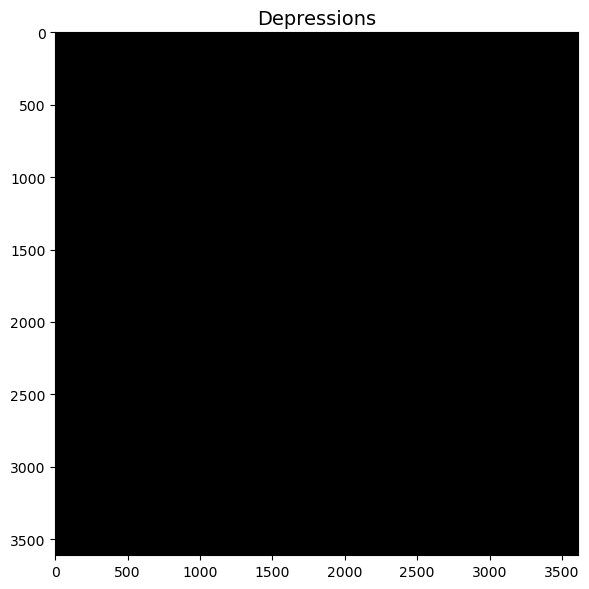

In [262]:
# Plot depressions
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(depressions, cmap='Greys_r', zorder=1)
plt.title('Depressions', size=14)
plt.tight_layout()

#### Filling depressions
Depressions can be filled using the `grid.fill_depressions` method:


In [263]:
# Fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)
depressions = grid.detect_depressions(flooded_dem)
assert not depressions.any()

#### Resolving flats
Flats can be resolved using the `grid.resolve_flats` method:


In [265]:
inflated_dem = grid.resolve_flats(flooded_dem)
flats = grid.detect_flats(inflated_dem)
# assert not flats.any()

#### Computing accumulation
After filling depressions and resolving flats, the flow direction can be determined as usual. Accumulation is computed using the grid.accumulation method.

In [267]:
# Compute flow direction based on corrected DEM
fdir = grid.flowdir(inflated_dem)

# Compute flow accumulation based on computed flow direction
acc = grid.accumulation(fdir)

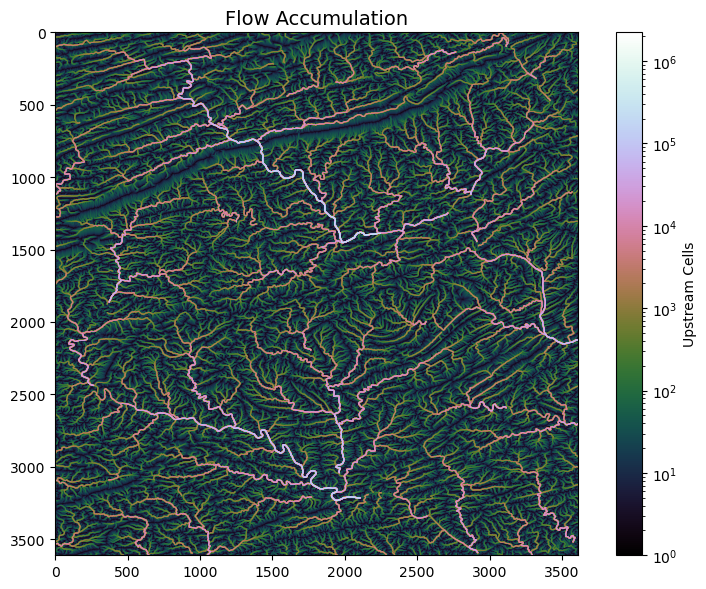

In [268]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(acc, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.tight_layout()

In [269]:
# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc > 200)

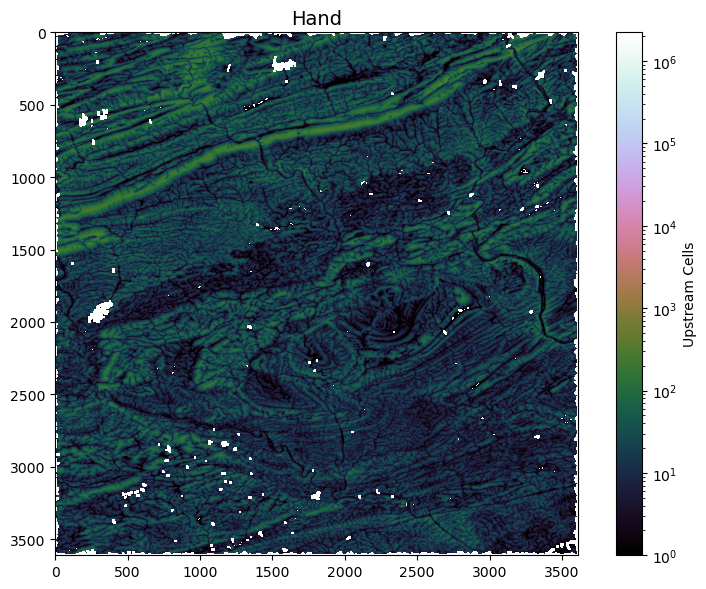

In [270]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(hand, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Hand', size=14)
plt.tight_layout()

#### Estimating inundation extent (constant channel depth)


In [271]:
threshold = 5
inundation_extent = np.where(hand < threshold, threshold - hand, np.nan)

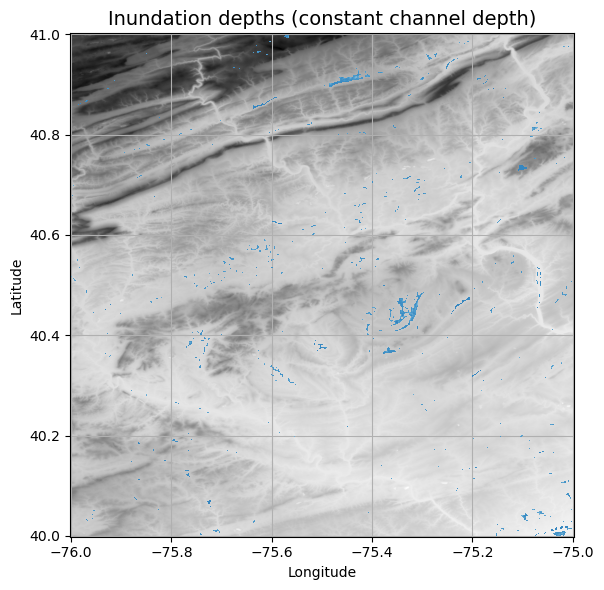

In [272]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(dem_view, extent=grid.extent, cmap='Greys', zorder=1)
plt.imshow(inundation_extent, extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=2)
plt.grid(zorder=0)
plt.title('Inundation depths (constant channel depth)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

With consideration of the rainfall and runoff, to estimate the flood vulnerable area

	1.	Compute HAND:
	•	Use PySheds to calculate HAND, which represents the height of each cell above the nearest drainage.
	2.	Incorporate Rainfall Data:
	•	Include rainfall data, either as uniform or spatially distributed values.
	3.	Calculate Runoff:
	•	Multiply rainfall by a runoff coefficient that accounts for land surface characteristics (e.g., soil type, impervious surfaces).
	4.	Compare Runoff and HAND:
	•	Determine areas where runoff depth exceeds HAND values to identify flooded or vulnerable areas.
	5.	Analyze and Save Results:
	•	Generate maps or compute statistics for the vulnerable areas.

#### Step 4: Incorporate Rainfall


1.	Uniform Rainfall:
If rainfall is uniform across the study area, multiply the normalized flow accumulation by the rainfall intensity:

2. Spatially Distributed Rainfall: If you have spatial rainfall data (e.g., from weather models), load the raster and multiply it cell by cell:

In [274]:
rainfall = 0.5  # Rainfall in meters (uniform value)

# with rasterio.open('rainfall.tiff') as src:
#     rainfall = src.read(1)  # Load spatial rainfall raster

In [275]:
runoff_coefficient = 0.7  # Example: 70% of rainfall becomes runoff
runoff = rainfall * runoff_coefficient

In [60]:
rainfall_intensity = 50  # in mm, e.g., total rainfall for an event
potential_flood = flow_accum * rainfall_intensity

# with rasterio.open("rainfall.tif") as src:
#     rainfall = src.read(1)

# potential_flood = flow_accum * rainfall

#### Step 5: Analyze Vulnerable Areas
Identify areas exceeding a certain flood potential threshold:

In [63]:
flood_threshold = 0.2  # Adjust as needed
vulnerable_areas = (potential_flood > flood_threshold)


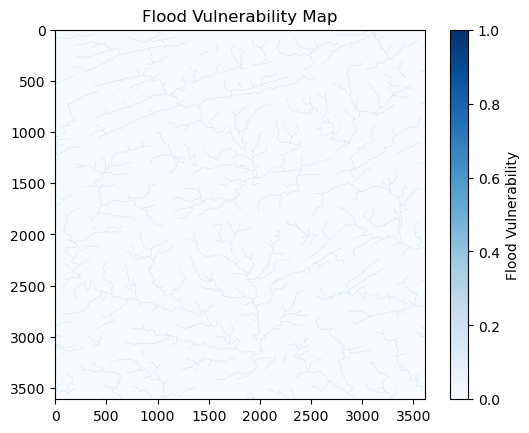

In [64]:
import matplotlib.pyplot as plt
plt.imshow(vulnerable_areas, cmap='Blues')
plt.colorbar(label='Flood Vulnerability')
plt.title("Flood Vulnerability Map")
plt.show()

#### With consideration of the Land use/cover data

1. Obtain and Preprocess LULC Data

	•	Source Data:
	•	LULC raster datasets, such as those from the USGS National Land Cover Database (NLCD), ESA CCI Land Cover, or other regional sources.
	•	Ensure the LULC data is at a compatible resolution with your DEM.
	•	Reproject and Resample:
	•	Reproject the LULC raster to match the DEM coordinate reference system (CRS) and resolution:

In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Reproject LULC raster
with rasterio.open("lulc.tif") as src:
    transform, width, height = calculate_default_transform(
        src.crs, 'EPSG:your_dem_crs', src.width, src.height, *src.bounds
    )
    profile = src.profile.copy()
    profile.update({
        'crs': 'EPSG:your_dem_crs',
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('lulc_reprojected.tif', 'w', **profile) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs='EPSG:your_dem_crs',
            resampling=Resampling.nearest
        )

2. Classify LULC Categories

Assign values to LULC categories based on their influence on runoff and infiltration. For example:
	•	Urban Areas: High runoff coefficient (e.g., 0.8–0.95).
	•	Forests/Grasslands: Low runoff coefficient (e.g., 0.1–0.3).
	•	Agricultural Land: Moderate runoff coefficient (e.g., 0.3–0.5).

In [65]:
lulc_runoff_mapping = {
    11: 0.95,  # Open Water
    21: 0.85,  # Developed, Open Space
    22: 0.8,   # Developed, Low Intensity
    23: 0.6,   # Developed, Medium Intensity
    24: 0.3,   # Developed, High Intensity
    41: 0.1,   # Deciduous Forest
    81: 0.4,   # Pasture/Hay
    # Add other classes as needed
}

3. Convert LULC to Runoff Coefficients

Using the LULC raster, apply the mapping to generate a runoff coefficient raster:

In [ ]:
import numpy as np

with rasterio.open('lulc_reprojected.tif') as src:
    lulc = src.read(1)

# Apply mapping
runoff_coefficients = np.vectorize(lulc_runoff_mapping.get)(lulc)

4. Integrate LULC into Flood Potential

Modify the flow accumulation or rainfall data to account for runoff:
	•	Adjust Rainfall Based on LULC:
Multiply rainfall intensity by the runoff coefficient for each cell:

In [ ]:
potential_runoff = rainfall * runoff_coefficients

	•	Incorporate into Flow Accumulation:
Adjust the flow accumulation to include LULC effects:

In [ ]:
adjusted_flow_accum = flow_accum * runoff_coefficients

In [ ]:
import matplotlib.pyplot as plt

flood_vulnerability = adjusted_flow_accum  # Or use potential_runoff

plt.imshow(flood_vulnerability, cmap='Blues')
plt.colorbar(label='Flood Vulnerability')
plt.title("Flood Vulnerability Map with LULC Consideration")
plt.show()

6. Additional Considerations

	•	Infiltration Modeling: If infiltration is significant (e.g., for porous soils), you can combine soil maps with LULC data to refine the runoff coefficients further.
	•	Temporal Rainfall Data: Use dynamic rainfall data (e.g., hourly or daily intensity) to account for variations in storm events.
	•	Validation: Compare your results with observed flood data or historical events for accuracy.


Extensions

	•	Coupling with Hydrological Models: Integrate PyShed outputs into more advanced models (e.g., SWAT, HEC-RAS) for deeper analysis.
	•	Scenario Testing: Simulate different land use changes (e.g., urbanization, reforestation) to evaluate their impact on flood vulnerability.

In [ ]:
import richdem as rd


`conda install conda-forge::richdem`

`conda install conda-forge/label/broken::richdem`

`conda install conda-forge/label/cf202003::richdem`

Preprocessing: Prepare the DEM by filling depressions using richdem or another method to ensure accurate hydrological modeling
We'll use the richdem FillDepressions functions to fill possible depressions on the DEM file


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood+Epsilon
C Barnes, R., Lehman, C., Mulla, D., 2014. Priority-flood: An optimal depression-filling and watershed-labeling algorithm for digital elevation models. Computers & Geosciences 62, 117–127. doi:10.1016/j.cageo.2013.04.024

c topology = D8
p Setting up boolean flood array matrix...
p Adding cells to the priority queue...
p Performing Priority-Flood+Epsilon...
t succeeded in 1.84371 s===================== ] (99% - 0.0s - 1 threads)
m Cells processed = 13046544
m Cells in pits = 372071
W W In assigning negligible gradients to depressions, some depressions rose above the surrounding cells. This implies that a larger storage type should be used. The problem occured for 218 of 13046544.


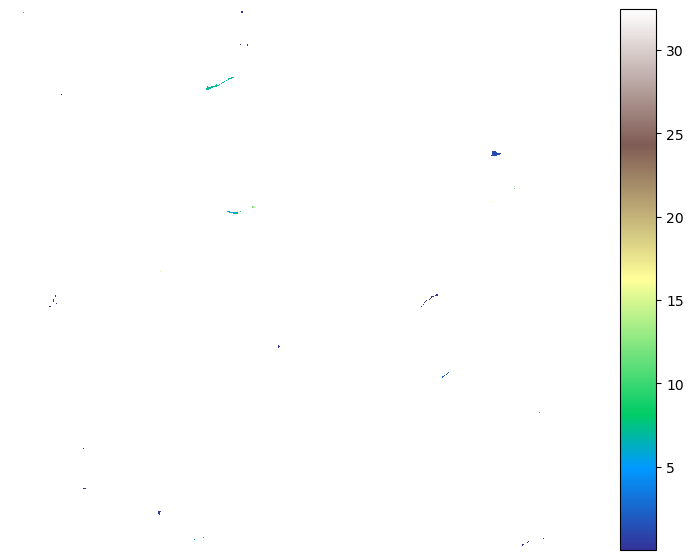

In [6]:
dem_filled = rd.FillDepressions(dem_rd, epsilon=True, in_place=False)

# check the areas that changed
dem_diff = dem_filled - dem_rd
diff_fig = rd.rdShow(dem_diff, ignore_colours=[0], axes=False, cmap='terrain', figsize=(8,6))

In [7]:
# saving the filled DEM
output_path = 'dem_filled.tif'

driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_path, dem_dataset.RasterXSize, dem_dataset.RasterYSize, 1, gdal.GDT_Float32)

# Set the geotransform and projection from the original DEM
out_ds.SetGeoTransform(geotransform)
out_ds.SetProjection(projection)

# Write the filled DEM data to the output file
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(np.array(dem_filled))

# Set the NoData value if present
if nodata_value is not None:
    out_band.SetNoDataValue(nodata_value)

# Flush data to disk and close the datasets
out_band.FlushCache()
out_ds = None
ds = None

print(f"Filled DEM saved to {output_path}")

Filled DEM saved to dem_filled.tif


Processing
The processing phase comprises 4 steps:

- Step 1: Calculating Flow Directions
Calculate flow directions using a D8 or similar flow direction algorithm. This determines where water would flow from each pixel.
- Step 2: Calculating Flow Accumulation
Use the flow direction data to compute flow accumulation. This will identify areas where water tends to accumulate, which helps in understanding drainage patterns.
- Step 3: Extracting Stream Network
Extract the stream network based on the flow accumulation. Streams are usually defined by a threshold in flow accumulation, where pixels exceeding the threshold are considered part of the drainage network.
- Step 4: Calculating HAND (Height Above Nearest Drainage)
Calculate the Height Above Nearest Drainage (HAND) using whiteboxtools. The HAND calculation determines the vertical height of each cell above the nearest stream in the network.

In [8]:
from WBT.whitebox_tools import WhiteboxTools


ModuleNotFoundError: No module named 'WBT'

In [3]:
# load MDE file using gdal
dem_path = 'USGS_1_n41w076_20221115.tif'
dem_dataset = gdal.Open(dem_path)
dem_band = dem_dataset.GetRasterBand(1)
dem_array = dem_band.ReadAsArray()

# Get necessary metadata for saving later
geotransform = dem_dataset.GetGeoTransform()
projection = dem_dataset.GetProjection()
nodata_value = dem_band.GetNoDataValue()

Visualize the DEM

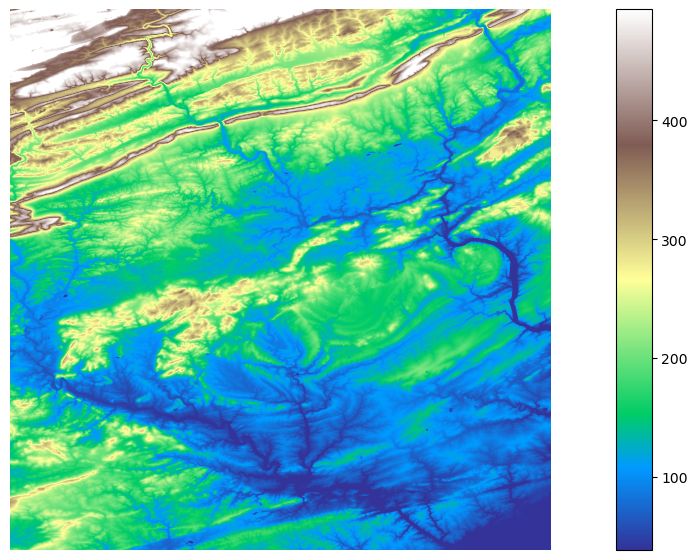

In [4]:
# plot the DEM file with the rdShow function
dem_rd = rd.rdarray(dem_array, no_data=nodata_value)
dem_fig = rd.rdShow(dem_rd, ignore_colours=[0], axes=False, cmap='terrain', figsize=(8,6))


In [20]:
# !pip install pysheds
# !pip install seaborn

In [12]:
# Read elevation raster
# ----------------------------
from pysheds.grid import Grid

grid = Grid.from_raster('USGS_1_n41w076_20221115.tif')
dem = grid.read_raster('USGS_1_n41w076_20221115.tif')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [29]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

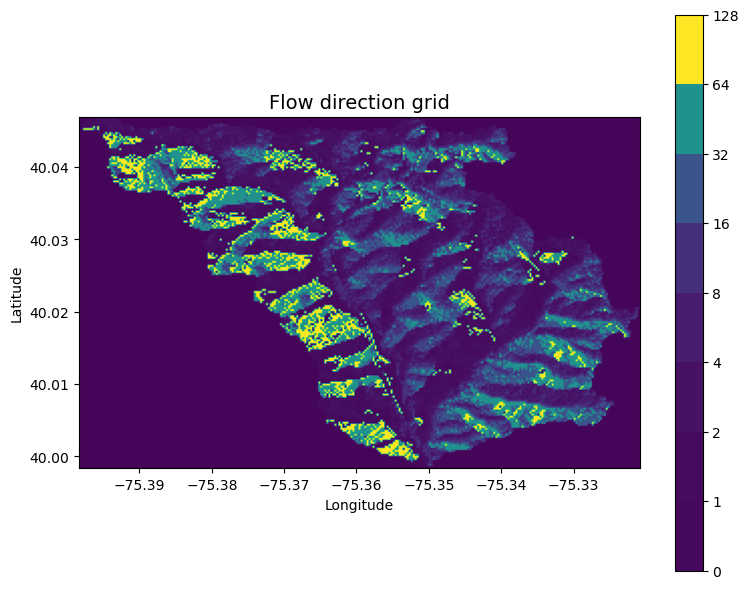

In [31]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

#### Compute accumulation from flow direction

In [15]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

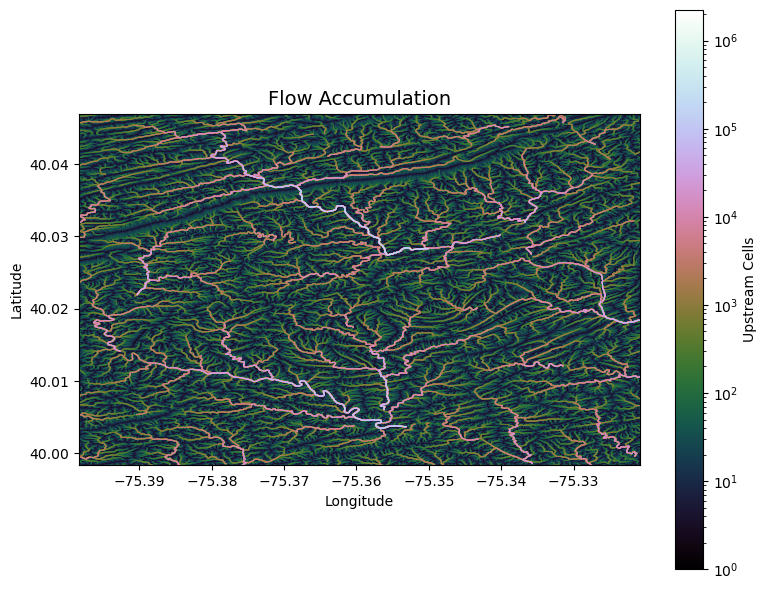

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns


fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

#### Delineate catchment from flow direction


In [22]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = -97.294, 32.737
x, y = -75.33833410243246, 39.92000254636596

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)


Text(0.5, 1.0, 'Delineated Catchment')

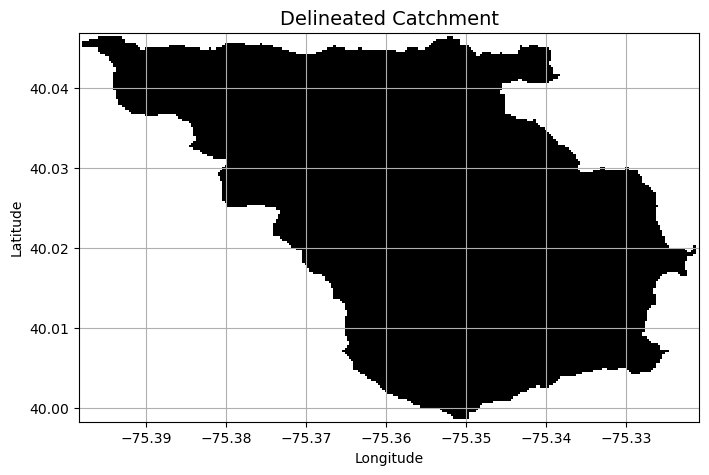

In [23]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

#### Extract the river network


In [34]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

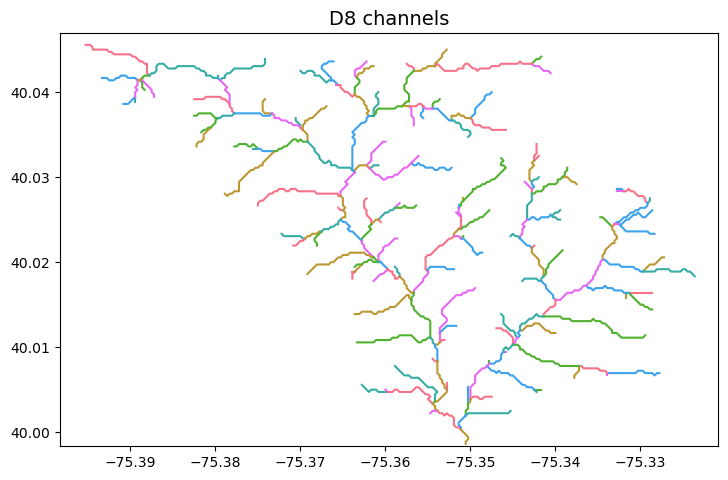

In [35]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)


In [36]:
# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc > 200)


In [40]:
x, y = -75.36273318272794, 40.02943850444447

# -75.3983333334292, 39.99833333341752, -75.32083333342663, 40.04694444453025

# Delineate a catchment
catch = grid.catchment(x=x, y=y, fdir=fdir, xytype='coordinate')

# Clip to the catchment
grid.clip_to(catch)

# Create a view of HAND in the catchment
hand_view = grid.view(hand, nodata=np.nan)

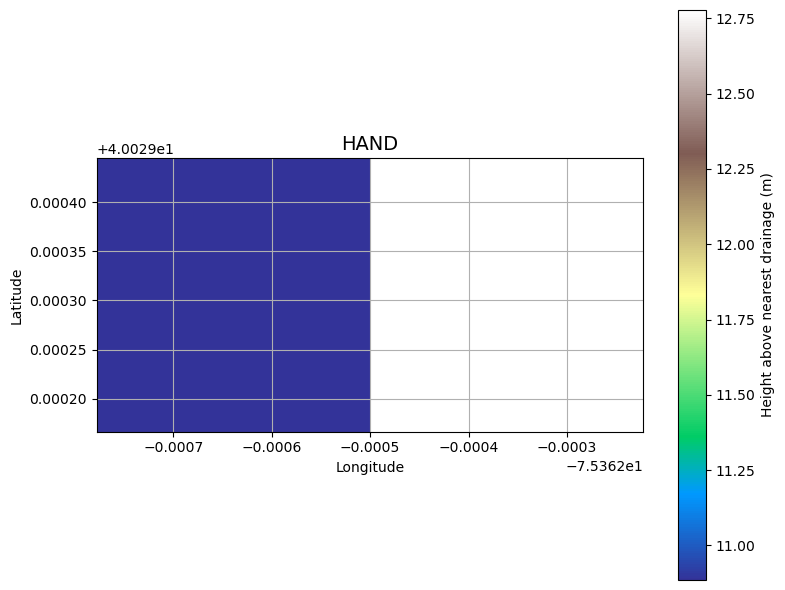

In [41]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.imshow(hand_view, 
           extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Height above nearest drainage (m)')
plt.grid(zorder=0)
plt.title('HAND', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [42]:
inundation_extent = np.where(hand_view < 3, 3 - hand_view, np.nan)


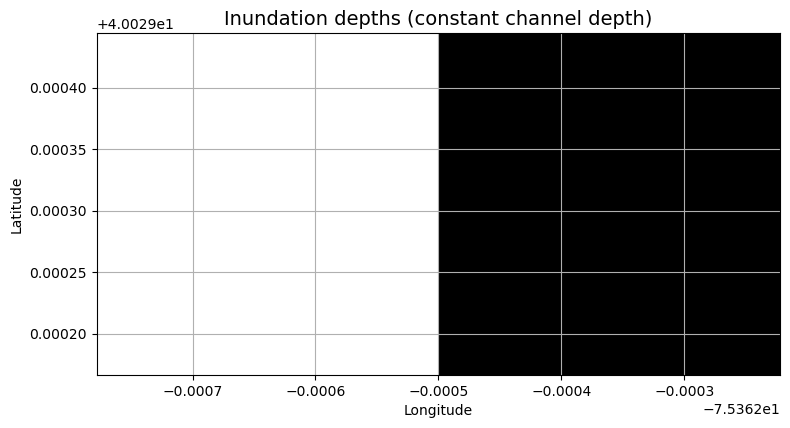

In [43]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(dem_view, extent=grid.extent, cmap='Greys', zorder=1)
plt.imshow(inundation_extent, extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=2)
plt.grid(zorder=0)
plt.title('Inundation depths (constant channel depth)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

#### Compute flow distance from flow direction


In [27]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')


Text(0.5, 1.0, 'Flow Distance')

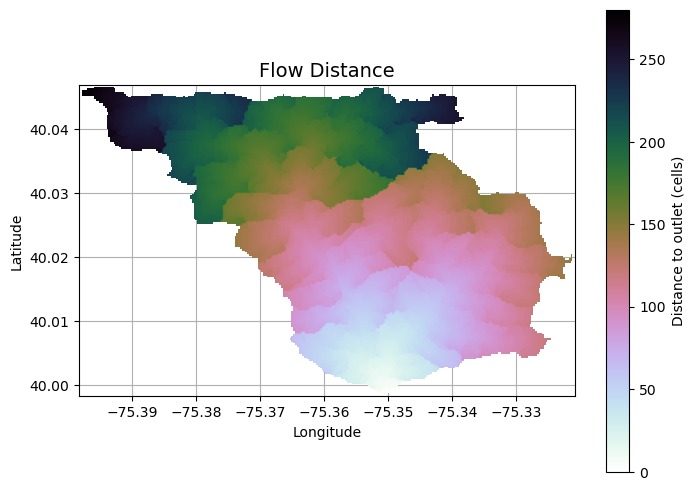

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)

In [ ]:
4. Post-Processing and Validation

	•	Overlay the results on land-use maps or critical infrastructure locations to assess impacts.
	•	Validate with historical flood data, if available.

	•	Rainfall-Runoff Model: PyShed does not simulate rainfall infiltration or runoff explicitly. You might need to integrate a simple runoff coefficient or use external models.
	•	Groundwater Interactions: If groundwater is a significant factor, consider coupling PyShed with tools like FloPy or external groundwater models.
	•	Resolution Dependency: High-resolution DEMs yield better results but can increase computation time.

#### Consider the land use/cover

1. Obtain and Preprocess LULC Data

	-	Source Data:
	-	LULC raster datasets, such as those from the USGS National Land Cover Database (NLCD), ESA CCI Land Cover, or other regional sources.
	-	Ensure the LULC data is at a compatible resolution with your DEM.
	-	Reproject and Resample:
	-	Reproject the LULC raster to match the DEM coordinate reference system (CRS) and resolution:

In [4]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Reproject LULC raster
with rasterio.open("lulc.tif") as src:
    transform, width, height = calculate_default_transform(
        src.crs, 'EPSG:your_dem_crs', src.width, src.height, *src.bounds
    )
    profile = src.profile.copy()
    profile.update({
        'crs': 'EPSG:your_dem_crs',
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('lulc_reprojected.tif', 'w', **profile) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs='EPSG:your_dem_crs',
            resampling=Resampling.nearest
        )

2. Classify LULC Categories

Assign values to LULC categories based on their influence on runoff and infiltration. For example:
	•	Urban Areas: High runoff coefficient (e.g., 0.8–0.95).
	•	Forests/Grasslands: Low runoff coefficient (e.g., 0.1–0.3).
	•	Agricultural Land: Moderate runoff coefficient (e.g., 0.3–0.5).


In [ ]:
lulc_runoff_mapping = {
    11: 0.95,  # Open Water
    21: 0.85,  # Developed, Open Space
    22: 0.8,   # Developed, Low Intensity
    23: 0.6,   # Developed, Medium Intensity
    24: 0.3,   # Developed, High Intensity
    41: 0.1,   # Deciduous Forest
    81: 0.4,   # Pasture/Hay
    # Add other classes as needed
}

3. Convert LULC to Runoff Coefficients


In [ ]:
import numpy as np

with rasterio.open('lulc_reprojected.tif') as src:
    lulc = src.read(1)

# Apply mapping
runoff_coefficients = np.vectorize(lulc_runoff_mapping.get)(lulc)

4. Integrate LULC into Flood Potential

Modify the flow accumulation or rainfall data to account for runoff:
	•	Adjust Rainfall Based on LULC:
Multiply rainfall intensity by the runoff coefficient for each cell:

In [ ]:
potential_runoff = rainfall * runoff_coefficients

	•	Incorporate into Flow Accumulation:


In [ ]:
adjusted_flow_accum = flow_accum * runoff_coefficients

### Step 1. Download the DEM automatically from USGS

https://apps.nationalmap.gov/downloader/

An arc second is equivalent to 1/3600th of 1 degree or equal to 1/1,296,000 of a full circle.

- 1-arc-second (~30m)	`Elevation/1/TIFF/current/`
- 1/3-arc-second (~10m)	`Elevation/13/TIFF/current/`
- 1/9-arc-second (~3m)	`Elevation/19/TIFF/current/`

- 1m resolution DEM  `https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/TIFF/current/{tile_name}/USGS_1m_{tile_name}.tif`

`n40w076` → Represents the latitude (40°N) and longitude (76°W) of the bottom-left corner. `USGS_1_n40w076.tif` → USGS 1-arcsecond DEM for that region. To get a different tile, change `n40w076` in the URL to the coordinates of your area of interest.

In [6]:
import requests

tile_name = 'n38w105'
tile_name = 'n39w076'
tile_name = 'n40w076'

# Example download URL for a tile, here the 1 mean 1-arc second DEM, resolution around 30m
tile_url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/%s/USGS_1_%s.tif"%(tile_name, tile_name)

# Download the tile
response = requests.get(tile_url)

with open("%s.tif"%(tile_name), "wb") as file:
    file.write(response.content)

print("DEM tile downloaded: %s.tif"%(tile_name))


DEM tile downloaded: n40w076.tif


Here we can create a function that would return the tile name for any specified coordinate

In [56]:
def get_tile_name(lat, lon):
    """
    Returns the USGS tile name formatted correctly (e.g., 'n39w076').
    """
    lat_tile = f"n{int(abs(lat)):02d}" if lat >= 0 else f"s{int(abs(lat)):02d}"
    lon_tile = f"w{int(abs(lon)):03d}" if lon < 0 else f"e{int(abs(lon)):03d}"
    return f"{lat_tile}{lon_tile}"

# Example: Get tile for Philadelphia (39.95°N, 75.16°W)
lat, lon = 39.95, -75.16
tile_name = get_tile_name(lat, lon)
print("DEM Tile Name:", tile_name)

DEM Tile Name: n39w075


In [53]:
tile_name = 'n40w076'

# Example download URL for a tile, here the 1 mean 1-arc second DEM, resolution around 30m
tile_url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/%s/USGS_1_%s.tif"%(tile_name, tile_name)

# Download the tile
response = requests.get(tile_url)

with open("%s.tif"%(tile_name), "wb") as file:
    file.write(response.content)

print("DEM tile downloaded: %s.tif"%(tile_name))

DEM tile downloaded: n38w075.tif


In [54]:
tile_url

'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/n38w075/USGS_1_n38w075.tif'

Usually, we want to get the all potential tiles in a certain area, here we create a function to return all the tile names in a region

In [47]:
def get_tiles_in_bbox(min_lat, max_lat, min_lon, max_lon):
    """
    Returns a list of tile names covering a bounding box.
    """
    tile_list = []
    for lat in range(int(min_lat), int(max_lat) + 1):
        for lon in range(int(min_lon), int(max_lon) + 1):
            tile_list.append(get_tile_name(lat, lon))
    return tile_list

# Example: Get tiles for an area (Philadelphia to NYC region)
tiles = get_tiles_in_bbox(38, 41, -76, -74)
print("Tiles to Download:", tiles)

Tiles to Download: ['n38w076', 'n38w075', 'n38w074', 'n39w076', 'n39w075', 'n39w074', 'n40w076', 'n40w075', 'n40w074', 'n41w076', 'n41w075', 'n41w074']


Now we can start to download 

In [51]:
import requests
import os

def download_dem_1arc(tile_name, save_path="."):
    """
    Downloads a 1-arc-second (~30m) DEM tile from USGS TNM.
    
    Parameters:
        tile_name (str): Tile name (e.g., "n39w076").
        save_path (str): Directory to save the DEM file.
    """
    base_url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current"
    url = f"{base_url}/{tile_name}/USGS_1_{tile_name}.tif"
    
    output_file = os.path.join(save_path, f"{tile_name}.tif")
    
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        # with open(output_file, "wb") as file:
        #     for chunk in response.iter_content(1024):
        #         file.write(chunk)
        print(f"✅ DEM Tile {tile_name} downloaded successfully!")
    else:
        print(f"❌ Error: Tile {tile_name} not found. Check availability.")
        print(url)
# Download multiple tiles
save_directory = "DEM_Tiles"
os.makedirs(save_directory, exist_ok=True)  # Create folder if it doesn't exist

for tile in tiles:
    download_dem_1arc(tile, save_directory)

✅ DEM Tile n38w076 downloaded successfully!
❌ Error: Tile n38w075 not found. Check availability.
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/n38w075/USGS_1_n38w075.tif
❌ Error: Tile n38w074 not found. Check availability.
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/n38w074/USGS_1_n38w074.tif
✅ DEM Tile n39w076 downloaded successfully!
✅ DEM Tile n39w075 downloaded successfully!
❌ Error: Tile n39w074 not found. Check availability.
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/n39w074/USGS_1_n39w074.tif
✅ DEM Tile n40w076 downloaded successfully!
✅ DEM Tile n40w075 downloaded successfully!
❌ Error: Tile n40w074 not found. Check availability.
https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/n40w074/USGS_1_n40w074.tif
✅ DEM Tile n41w076 downloaded successfully!
✅ DEM Tile n41w075 downloaded successfully!
✅ DEM Tile n41w074 downloaded successfully!
